# Time Series Prediction

In [656]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K

## Read in Data

In [657]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [658]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [659]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
    dataX, dataY = [], []
    if len(input) != len(output):
        raise ValueError('Input and ouput do not have same length!')
    for i in range(len(input)-look_back-horizon):
        dataX.append(input[i:(i+look_back)])
        dataY.append(output[(i+look_back):(i+look_back+horizon)])
    # Shuffle windows
    if shuffle is True:
        dataX, dataY = shuffle(dataX, dataY, random_state=0)
    return np.array(dataX), np.array(dataY)

In [660]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [661]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [662]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.75
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

### Long Short-Term Memory

In [663]:
def train_lstm(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    #model.add(LSTM(96, return_sequences=True, name="LSTM_3"))
    #model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

### Convolutional Neural Network 

In [664]:
def train_cnn(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='elu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='elu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='elu', name='Dense_1'))
    #model.add(Dense(8, activation='elu', name='Dense_2'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [665]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D


def train_wavenet(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, trainX.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 

        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('elu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.2)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(2)(out)
    out = GlobalMaxPooling1D()(out)
    #out = GlobalAveragePooling1D(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict, history

In [666]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [667]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(65, 12, 40)
(65, 6)
(10, 12, 40)
(10, 6)


### Train Model

In [668]:
#Varying number of features

num_of_feats = 21
random_list = []

for i in range(num_of_feats):
        value = random.randint(0, 39)
        
        while value in random_list:
            value = random.randint(0, 39)
            
        random_list.append(value)        
        
random_list

[21, 19, 5, 25, 3, 30, 31, 11, 33, 38, 0, 9, 28, 29, 36, 18, 14, 15, 13, 16, 1]

In [669]:
#trainX = trainX[:, :, random_list]
print(trainX.shape)
#testX = testX[:, :, random_list]
print(testX.shape)

(65, 12, 40)
(10, 12, 40)


In [670]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict, history = train_wavenet(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 12, 40)       0                                            
__________________________________________________________________________________________________
conv1d_1319 (Conv1D)            (None, 12, 16)       656         input_39[0][0]                   
__________________________________________________________________________________________________
conv1d_1320 (Conv1D)            (None, 12, 32)       1056        conv1d_1319[0][0]                
__________________________________________________________________________________________________
conv1d_1321 (Conv1D)            (None, 12, 32)       1056        conv1d_1319[0][0]                
___________________________________________________________________________________________

Train on 52 samples, validate on 13 samples
Epoch 1/250
52/52 [==============================] - 2s 30ms/step - loss: 4785.9193 - r2_keras: -199.1037 - val_loss: 4477.9159 - val_r2_keras: -264.6171
Epoch 2/250
52/52 [==============================] - 0s 4ms/step - loss: 4280.9747 - r2_keras: -179.3799 - val_loss: 3545.8665 - val_r2_keras: -208.7967
Epoch 3/250
52/52 [==============================] - 0s 4ms/step - loss: 2626.5288 - r2_keras: -111.1862 - val_loss: 1437.8355 - val_r2_keras: -83.0826
Epoch 4/250
52/52 [==============================] - 0s 4ms/step - loss: 496.1121 - r2_keras: -19.7017 - val_loss: 81.8383 - val_r2_keras: -3.7963
Epoch 5/250
52/52 [==============================] - 0s 4ms/step - loss: 151.7866 - r2_keras: -5.0066 - val_loss: 33.5525 - val_r2_keras: -1.0881
Epoch 6/250
52/52 [==============================] - 0s 3ms/step - loss: 37.2063 - r2_keras: -0.5669 - val_loss: 66.9745 - val_r2_keras: -2.7554
Epoch 7/250
52/52 [==============================] - 0s 3ms

Epoch 57/250
52/52 [==============================] - 0s 3ms/step - loss: 4.6266 - r2_keras: 0.7860 - val_loss: 5.7097 - val_r2_keras: 0.6744
Epoch 58/250
52/52 [==============================] - 0s 3ms/step - loss: 4.2299 - r2_keras: 0.8115 - val_loss: 6.3182 - val_r2_keras: 0.6597
Epoch 59/250
52/52 [==============================] - 0s 3ms/step - loss: 3.8399 - r2_keras: 0.8395 - val_loss: 4.6163 - val_r2_keras: 0.7393
Epoch 60/250
52/52 [==============================] - 0s 3ms/step - loss: 3.7133 - r2_keras: 0.8439 - val_loss: 4.3047 - val_r2_keras: 0.7525
Epoch 61/250
52/52 [==============================] - 0s 4ms/step - loss: 3.6416 - r2_keras: 0.8428 - val_loss: 4.8078 - val_r2_keras: 0.7365
Epoch 62/250
52/52 [==============================] - 0s 4ms/step - loss: 3.2068 - r2_keras: 0.8659 - val_loss: 5.2367 - val_r2_keras: 0.7154
Epoch 63/250
52/52 [==============================] - 0s 3ms/step - loss: 3.1250 - r2_keras: 0.8744 - val_loss: 4.8487 - val_r2_keras: 0.7360
Epoch 

52/52 [==============================] - 0s 3ms/step - loss: 0.5474 - r2_keras: 0.9779 - val_loss: 2.8629 - val_r2_keras: 0.8290
Epoch 115/250
52/52 [==============================] - 0s 3ms/step - loss: 0.5119 - r2_keras: 0.9785 - val_loss: 2.9280 - val_r2_keras: 0.8250
Epoch 116/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4786 - r2_keras: 0.9807 - val_loss: 2.9979 - val_r2_keras: 0.8186
Epoch 117/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4826 - r2_keras: 0.9793 - val_loss: 2.9239 - val_r2_keras: 0.8212
Epoch 118/250
52/52 [==============================] - 0s 4ms/step - loss: 0.4712 - r2_keras: 0.9772 - val_loss: 3.0197 - val_r2_keras: 0.8144
Epoch 119/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4800 - r2_keras: 0.9786 - val_loss: 2.8782 - val_r2_keras: 0.8281
Epoch 120/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4779 - r2_keras: 0.9780 - val_loss: 2.9376 - val_r2_keras: 0.8213
Epoch 121/250

52/52 [==============================] - 0s 5ms/step - loss: 0.3023 - r2_keras: 0.9879 - val_loss: 2.7907 - val_r2_keras: 0.8306
Epoch 172/250
52/52 [==============================] - 0s 6ms/step - loss: 0.2860 - r2_keras: 0.9862 - val_loss: 2.6866 - val_r2_keras: 0.8372
Epoch 173/250
52/52 [==============================] - 0s 5ms/step - loss: 0.2878 - r2_keras: 0.9859 - val_loss: 2.9118 - val_r2_keras: 0.8238
Epoch 174/250
52/52 [==============================] - 0s 6ms/step - loss: 0.2851 - r2_keras: 0.9870 - val_loss: 2.8052 - val_r2_keras: 0.8306
Epoch 175/250
52/52 [==============================] - 0s 7ms/step - loss: 0.2783 - r2_keras: 0.9878 - val_loss: 2.8865 - val_r2_keras: 0.8250
Epoch 176/250
52/52 [==============================] - 0s 6ms/step - loss: 0.3175 - r2_keras: 0.9862 - val_loss: 2.7893 - val_r2_keras: 0.8276
Epoch 177/250
52/52 [==============================] - 0s 5ms/step - loss: 0.2755 - r2_keras: 0.9886 - val_loss: 2.7623 - val_r2_keras: 0.8299
Epoch 178/250

52/52 [==============================] - 0s 4ms/step - loss: 0.2059 - r2_keras: 0.9916 - val_loss: 2.8496 - val_r2_keras: 0.8248
Epoch 229/250
52/52 [==============================] - 0s 4ms/step - loss: 0.1926 - r2_keras: 0.9919 - val_loss: 2.5306 - val_r2_keras: 0.8450
Epoch 230/250
52/52 [==============================] - 0s 4ms/step - loss: 0.1986 - r2_keras: 0.9911 - val_loss: 2.5933 - val_r2_keras: 0.8378
Epoch 231/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2256 - r2_keras: 0.9910 - val_loss: 2.7137 - val_r2_keras: 0.8341
Epoch 232/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2018 - r2_keras: 0.9908 - val_loss: 2.6379 - val_r2_keras: 0.8383
Epoch 233/250
52/52 [==============================] - 0s 4ms/step - loss: 0.1990 - r2_keras: 0.9917 - val_loss: 2.7226 - val_r2_keras: 0.8288
Epoch 234/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2031 - r2_keras: 0.9918 - val_loss: 2.8124 - val_r2_keras: 0.8301
Epoch 235/250

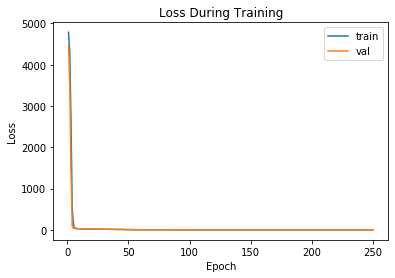

In [671]:
plot_model_history(history)

### Prediction and Plot

Forecast: [[70.943436 70.205185 67.97012  64.947784 61.503765 58.94846 ]]


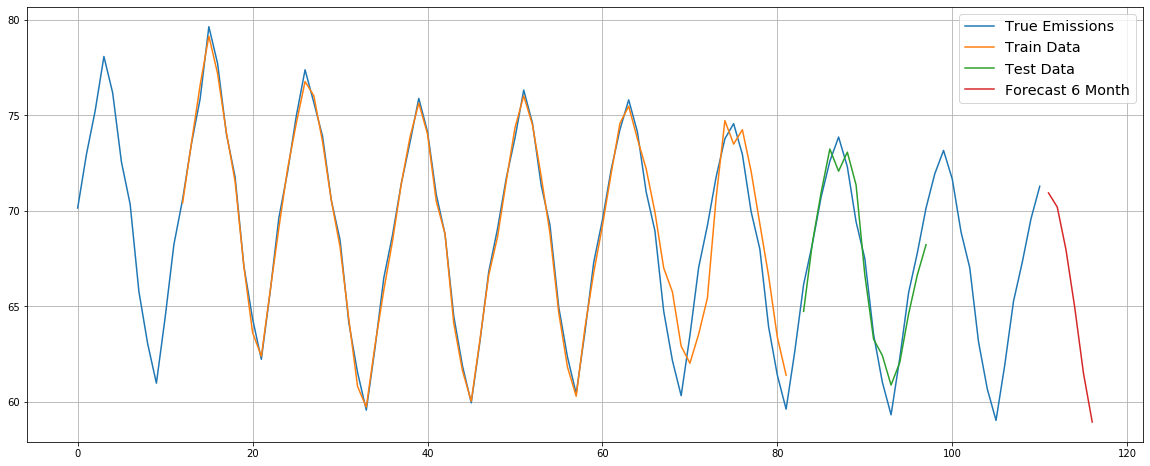

In [691]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, trainX.shape[2]))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :trainX.shape[2]]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,8))
line1 = plt.plot(emission_data[:], label='True Emissions')
line2 = plt.plot(trainPredictPlot[:], label='Train Data')
plt.plot(testPredictPlot[:], label='Test Data')
plt.plot(forecastPlot[:], label='Forecast 6 Month')
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()